<a href="https://colab.research.google.com/github/msiplab/EicEngLabIV/blob/master/example02_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験Ⅳ－２　時系列データの分析

1. サンプルデータの読み込み
1. 平均 $\mu$ と分散 $\gamma_0$ の推定
1. 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

新潟大学工学部工学科　電子情報通信プログラム

## 準備

In [1]:
!pip install japanize-matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore') #警告を無視（コメントアウト推奨）

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib #日本語化matplotlib
sns.set(font="IPAexGothic") #日本語フォント設定

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=8d6c60c38e09094765751ba2ec2c72b7cdb458447d9bed65b4c2dfeb3edad9fb
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib


## サンプルデータの読み込み

WAV形式の音響データ（モノラル）を読込

https://docs.python.org/ja/3/library/wave.html#https://docs.python.org/ja/3/library/wave.html#


In [2]:
import wave
import requests
from io import BytesIO

url = 'https://github.com/msiplab/EicEngLabIV/blob/develop/data/fannoise.wav?raw=true'
response = requests.get(url)
wf = wave.open(BytesIO(response.content),mode='rb')
buf = wf.readframes(-1)
ch  = wf.getnchannels()
fs  = wf.getframerate()
nf  = wf.getnframes()
y   = np.frombuffer(buf, dtype='int16')
print('チャンネル数 = {:d} ch, 標本化周波数 = {:f} Hz, 長さ {:f} 秒 '.format(ch, fs, nf/fs))

# ステレオならモノラルに変換
if ch == 2:
    y = y.reshape(-1, 2)    # 2列（左・右）に変形
    y = y.mean(axis=1).astype('int16')  # 左右平均してint16に戻す

チャンネル数 = 1 ch, 標本化周波数 = 48000.000000 Hz, 長さ 5.000000 秒 


## 時系列データをpandas.DataFrameオブジェクトに変換

pandas ライブラリの DataFrame オブジェクトに変換

- t: 時刻
- y: データの値

以下では0～0.5秒までのデータを抽出して分析を進める。

In [3]:
t = np.linspace(0,nf/fs,nf)
df_full= pd.DataFrame({'t': t, 'y': y})

tstart = 0.0
tend   = 0.5
df_timeseries = df_full[(df_full['t']>=tstart) & (df_full['t']<tend)]
display(df_timeseries)

,t,y
0,0.000000,-1298
1,0.000021,-1337
2,0.000042,-1427
3,0.000063,-1518
4,0.000083,-1543
...,...,...
23995,0.499898,-900
23996,0.499919,-896
23997,0.499940,-963
23998,0.499960,-1074


## 時系列データをプロット


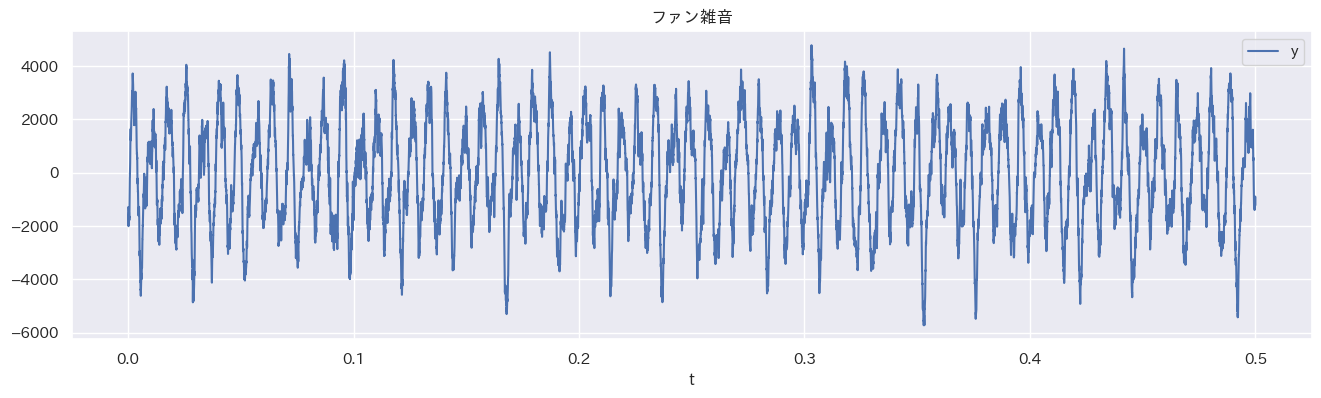

In [4]:
ax = df_timeseries.plot(x='t', y='y', figsize=(16,4), title='ファン雑音')


ヒストグラムをプロット

Text(0.5, 1.0, 'ファン騒音')

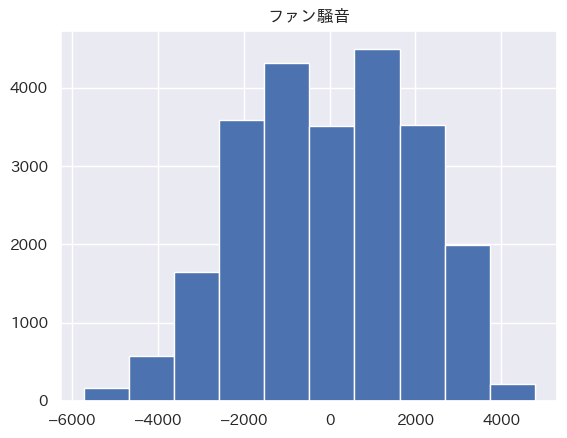

In [5]:
ax = df_timeseries.hist('y')
ax[0][0].set_title('ファン騒音')

## 平均 $\mu$ と分散 $\gamma_0$ の推定

- mean(): 標本平均を計算
- var(): 標本分散を計算

pandas.DataFrame オブジェクトのvar() メソッドのオプションで

- ddof = 0 とすると N で割る最尤推定
- ddof = 1 とすると (N-1)で割る不偏推定 ※デフォルト

In [6]:
y_series = df_timeseries['y']
mu = y_series.mean()
gamma0 = y_series.var(ddof=1)
print('平均 = {:f}, 分散 = {:f}'.format(mu,gamma0))

平均 = 1.870625, 分散 = 3869963.257106


## 自己共分散関数 $\gamma_k$ と自己相関関数 $\rho_k$ の推定

y_series は pandas.Series のオブジェクトとなっている。
pandas.Seriesオブジェクトは以下のメソッドを備える。

- cov() は共分散の不偏推定を計算
- corr() は相関の不偏推定を計算

※不偏推定から最尤推定への切替はできない


In [7]:
nlags = 40
for lag in range(nlags+1):
    gammak = y_series.cov(y_series.shift(lag))
    rhok = y_series.corr(y_series.shift(lag))
    print('γ{0:d} = {1:f}, ρ{0:d} = {2:f}'.format(lag,gammak,rhok))

γ0 = 3869963.257106, ρ0 = 1.000000
γ1 = 3864650.025938, ρ1 = 0.998603
γ2 = 3851890.775528, ρ2 = 0.995280
γ3 = 3836574.081748, ρ3 = 0.991297
γ4 = 3819818.727928, ρ4 = 0.986943
γ5 = 3801531.247276, ρ5 = 0.982194
γ6 = 3782233.481458, ρ6 = 0.977187
γ7 = 3761829.930156, ρ7 = 0.971899
γ8 = 3740375.103800, ρ8 = 0.966343
γ9 = 3718521.576658, ρ9 = 0.960686
γ10 = 3696205.143500, ρ10 = 0.954909
γ11 = 3673012.620282, ρ11 = 0.948907
γ12 = 3649054.562009, ρ12 = 0.942707
γ13 = 3624389.462488, ρ13 = 0.936323
γ14 = 3598851.324066, ρ14 = 0.929712
γ15 = 3572290.565879, ρ15 = 0.922835
γ16 = 3544435.099202, ρ16 = 0.915623
γ17 = 3515189.172583, ρ17 = 0.908052
γ18 = 3484733.545191, ρ18 = 0.900169
γ19 = 3453068.146562, ρ19 = 0.891972
γ20 = 3420144.016245, ρ20 = 0.883448
γ21 = 3386132.177491, ρ21 = 0.874644
γ22 = 3351299.048110, ρ22 = 0.865627
γ23 = 3316022.475293, ρ23 = 0.856496
γ24 = 3280495.571253, ρ24 = 0.847302
γ25 = 3244434.750924, ρ25 = 0.837970
γ26 = 3207679.585828, ρ26 = 0.828460
γ27 = 3170427.634723,

## 時系列解析ライブラリ

時系列解析には，statsmodelsライブラリも利用できる。

- acovf() は自己共分散関数を計算
- acf() は自己相関関数を計算

各メソッドのオプション unbiased = True で不偏推定，Falseで最尤推定となる．


In [8]:
import statsmodels.api as sm
from statsmodels.tsa import stattools

print('自己共分散関数')
y_acovf = stattools.acovf(y_series,unbiased=True)
display(y_acovf)
print('自己相関関数')
y_acf = stattools.acf(y_series,adjusted=True)
display(y_acf)



自己共分散関数


array([3869802.00863711, 3864488.99490341, 3851730.27723606, ...,
       1480660.82423783, 1517879.08985983, 1589573.6036124 ])

自己相関関数


array([1.        , 0.99862706, 0.99533006, 0.99137222, 0.98704264,
       0.98231715, 0.97733061, 0.97205833, 0.96651441, 0.96086746,
       0.9551009 , 0.94910796, 0.94291721, 0.93654377, 0.92994473,
       0.92308144, 0.91588361, 0.90832648, 0.90045677, 0.89227445,
       0.88376687, 0.87497823, 0.86597738, 0.85686193, 0.8476818 ,
       0.83836371, 0.82886621, 0.81924034, 0.8095017 , 0.79967481,
       0.78982958, 0.77994248, 0.76993824, 0.75980991, 0.74952429,
       0.73898969, 0.72818328, 0.71717215, 0.70604883, 0.69488025,
       0.68367236, 0.67241318, 0.66111028, 0.64974833])

## 原系列のコレログラムの表示

自己相関のグラフをコレログラムとよぶ。コレログラムは次のコマンドで表示できる。

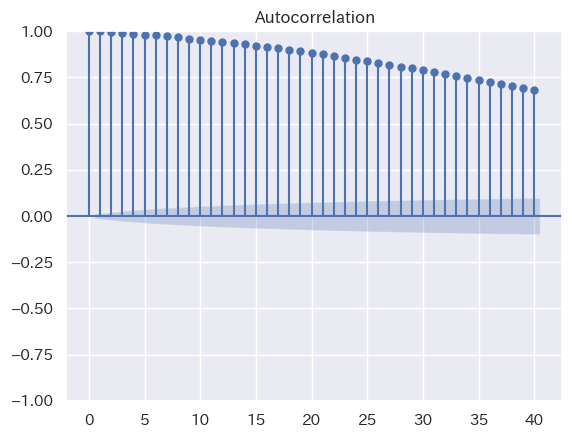

In [9]:
fig = sm.graphics.tsa.plot_acf(y_series,lags=nlags)

## 階差系列の分析

ひとつ前の値との差分をとった系列を階差系列とよぶ。

$\Delta y_n = y_{n} - y_{n-1}$


,t,y,y_diff
0,0.000000,-1298,NaN
1,0.000021,-1337,-39.0
2,0.000042,-1427,-90.0
3,0.000063,-1518,-91.0
4,0.000083,-1543,-25.0
...,...,...,...
23995,0.499898,-900,125.0
23996,0.499919,-896,4.0
23997,0.499940,-963,-67.0
23998,0.499960,-1074,-111.0


,y_diff
1,-39.0
2,-90.0
3,-91.0
4,-25.0
5,-71.0
...,...
23995,125.0
23996,4.0
23997,-67.0
23998,-111.0


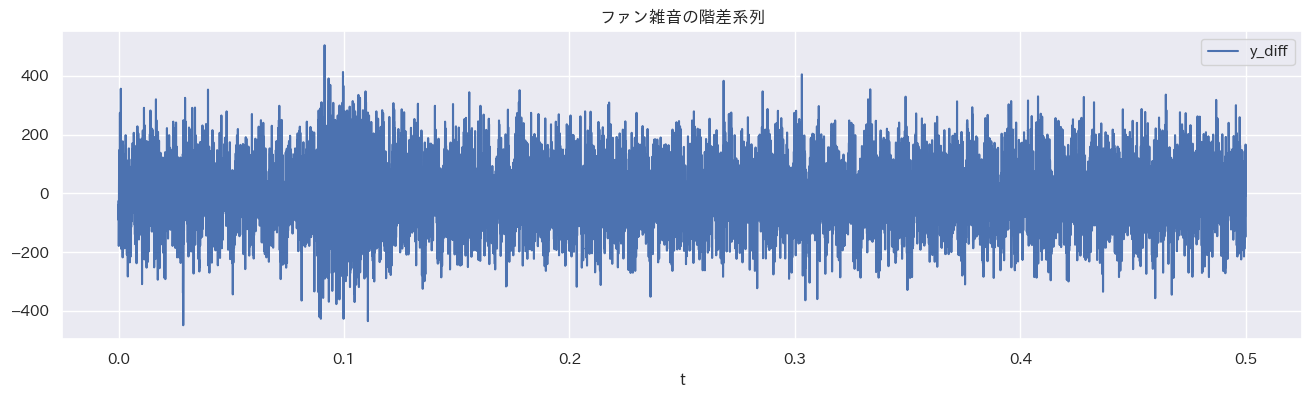

In [10]:
df_timeseries['y_diff'] = df_timeseries['y'].diff()
display(df_timeseries)
df_timeseries.plot(x='t', y='y_diff', figsize=(16,4), title='ファン雑音の階差系列')
y_diff_series = df_timeseries['y_diff'].dropna()
display(y_diff_series)

ヒストグラムをプロット


Text(0.5, 1.0, 'ファン騒音の階差系列')

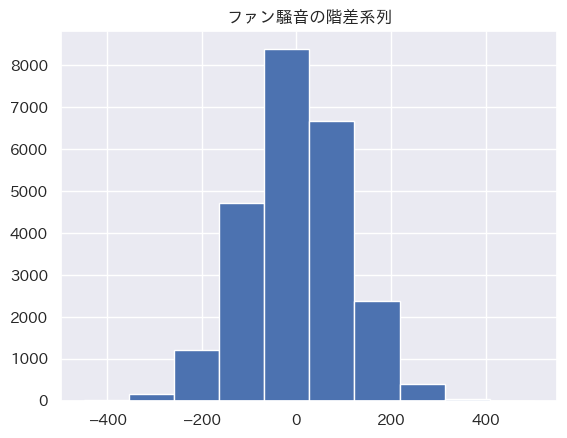

In [11]:
ax = df_timeseries.hist('y_diff')
ax[0][0].set_title('ファン騒音の階差系列')

原系列 $y_n$ と階差系列 $\Delta y_n$ のCSVへの出力

In [12]:
#df_timeseries.to_csv('./data/sample02_01.csv',index=False)